<a href="https://colab.research.google.com/github/cfont03/Anomaly-breast-cancer-detection/blob/main/train/1.%20Faster_R_CNN_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Data Upload

In [1]:
# Mount google drive
import zipfile
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Access and unzip images
!unzip "/content/gdrive/MyDrive/99_Output/all-mias.zip" -d "/"
print("DONE!")

Archive:  /content/gdrive/MyDrive/99_Output/all-mias.zip
replace /content/archive/all-mias/mdb081_mask.pgm? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: /content/archive/all-mias/mdb081_mask.pgm  
 extracting: /content/archive/all-mias/mdb105.pgm  
 extracting: /content/archive/all-mias/mdb197.pgm  
 extracting: /content/archive/all-mias/mdb300.pgm  
 extracting: /content/archive/all-mias/mdb171_vflip.jpeg  
 extracting: /content/archive/all-mias/mdb132_noise.jpeg  
 extracting: /content/archive/all-mias/mdb115_noise.jpeg  
 extracting: /content/archive/all-mias/mdb107_hflip.jpeg  
 extracting: /content/archive/all-mias/mdb195_noise.jpeg  
 extracting: /content/archive/all-mias/mdb191_vflip.jpeg  
 extracting: /content/archive/all-mias/mdb081_rotate.jpeg  
 extracting: /content/archive/all-mias/mdb283.pgm  
 extracting: /content/archive/all-mias/mdb195_mask.pgm  
 extracting: /content/archive/all-mias/mdb089.pgm  
 extracting: /content/archive/all-mias/mdb072.pgm  
 extracting:

In [3]:
# Importation of libraries
from tensorflow import keras 
print("Keras version   : ", keras.__version__)

%tensorflow_version 2.x
import tensorflow as tf

#from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
#from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten, Input,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D, TimeDistributed)
#from tensorflow.keras.layers.experimental.preprocessing import Resizing
#from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Model

%pylab inline
import cv2
import glob
import os
import matplotlib.pylab as plt

#from PIL import Image
import PIL.Image
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import Image
from keras.preprocessing import image as kp_image

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix

import seaborn as sns
from matplotlib import patches
import time

from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
from urllib import request
from tensorflow.keras import initializers
np.set_printoptions(suppress=True)
from pathlib import Path

import torch

Keras version   :  2.8.0
Populating the interactive namespace from numpy and matplotlib


In [4]:
# read csvs files from Data Cleansing
train = pd.read_csv("/content/gdrive/MyDrive/99_Output/images_preprocess_train.csv", sep = ";")
print('Training dataset: \n', train.head())

test = pd.read_csv("/content/gdrive/MyDrive/99_Output/images_preprocess_test.csv", sep = ";")
print('Testing dataset: \n', test.head())

Training dataset: 
    Unnamed: 0    name               features          size   cat  x_coord  \
0           0  mdb239  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CALC    567.0   
1           1  mdb223  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CALC    523.0   
2           2  mdb270  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CIRC    356.0   
3           3  mdb160  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  ARCH    536.0   
4           4  mdb226  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CALC    531.0   

   y_coord  radius                            image path   xmin   xmax   ymin  \
0    216.0      25  /content/archive/all-mias/mdb239.pgm  542.0  592.0  191.0   
1    542.0      29  /content/archive/all-mias/mdb223.pgm  494.0  552.0  513.0   
2     79.0      72  /content/archive/all-mias/mdb270.pgm  284.0  428.0    7.0   
3    505.0      61  /content/archive/all-mias/mdb160.pgm  475.0  597.0  444.0   
4    303.0       8  /content/archive/all-mias/mdb226.pgm  523.0  539.0  295.0   

    ymax  
0  241.0  
1  571.0

In [5]:
# show boundary box to image
def boundary_box (df):
  
  '''

  This function plots an image with its boundary boxes

  Params:
  1: name image
  8: path image
  9: min coord x
  10: max coord x
  11: min coord y
  12: max coord y

  '''

  image = input("introduce image name: ") 
  path = '/content/archive/all-mias/{:}'.format(image)
  im = cv2.imread(path)
  
  # generate x, y, width and height
  xmin = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,9]
  xmax = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,10]
  ymin = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,11]
  ymax = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,12]
  
  xmin, xmax, ymin, ymax = (xmin.values[0], xmax.values[0], ymin.values[0], ymax.values[0])
  width = xmax - xmin
  height = ymax - ymin

  # Create figure and axes
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(im)

  # Create a Rectangle patch
  rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='b', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

  plt.show()

introduce image name: mdb160.pgm


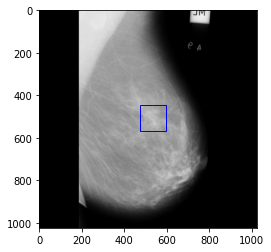

In [7]:
# apply to our df
boundary_box(train)

#1. Preprocess

Adapt training data to fit the model.

In [8]:
# keep interesting fields
train_ = train.iloc[:, [8, 9, 10, 11, 12]]
train_['height'] = 1024
train_['weight'] = 1024
train_['cat'] = train['cat']
train_.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,image path,xmin,xmax,ymin,ymax,height,weight,cat
493,/content/archive/all-mias/mdb181_hflip.jpeg,432.000000,482.000000,432.000000,482.000000,1024,1024,SPIC
494,/content/archive/all-mias/mdb181_noise.jpeg,465.000000,573.000000,608.000000,716.000000,1024,1024,SPIC
495,/content/archive/all-mias/mdb181_rotate.jpeg,-6.309271,316.131422,-6.309271,316.131422,1024,1024,SPIC
496,/content/archive/all-mias/mdb181_vflip.jpeg,475.000000,597.000000,475.000000,597.000000,1024,1024,SPIC
497,/content/archive/all-mias/mdb181_mask.pgm,465.000000,573.000000,608.000000,716.000000,1024,1024,SPIC


In [9]:
# resizing input images to fit into pretrained model, to extract features
def resize (df, h = 800, w = 800):
  
  '''

  Function returns resized images to specified size. Format: df
  Default is 800 x 800.

  Params:
  0: image path
  1: xmin
  2: xmax
  3: ymin
  4: ymax
  5: height original image
  6: weight original image
  7: label

  '''

  paths = []
  xmins = []
  xmaxs = []
  ymins = []
  ymaxs = []
  labels = []

  for i in df.iloc:
    img = cv2.imread(str(i[0]))
    img = cv2.resize(img, dsize = (h,w), interpolation = cv2.INTER_CUBIC)
    path, filename_ext = os.path.split(i[0])
    filename = os.path.basename(i[0]).split('.')[0]
    new_path = Path(str(path)+'/{:}_resize{:}'.format(filename, '.jpeg')) # generate new path
    status = cv2.imwrite(str(new_path), img)
    print("Image written to file-system " , new_path,  " :", status) # check if saved
    paths.append(new_path)

    x_factor = w / i[5]
    y_factor = h / i[6]

    # adapt bounding box accordingly
    xmin = i[1] * x_factor
    xmins.append(xmin)
    xmax = i[2] * x_factor
    xmaxs.append(xmax)
    ymin = i[3] * y_factor
    ymins.append(ymin)
    ymax = i[4] * y_factor
    ymaxs.append(ymax)

    labels.append(i[7])

  arr = np.array([paths, xmins, xmaxs, ymins, ymaxs, labels], dtype = object).T.tolist()
  df_ = pd.DataFrame(data = arr, columns = ['image path', 'xmin', 'xmax', 'ymin', 'ymax', 'labels'])
  
  return df_

In [10]:
# apply to df
train_re = resize(train_, 800, 800)

Image written to file-system  /content/archive/all-mias/mdb239_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb223_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb270_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb160_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb226_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb209_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb021_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb179_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb244_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb150_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb069_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb222_resize.jpeg  : True
Imag

In [11]:
train_re.head() # check results

,image path,xmin,xmax,ymin,ymax,labels
0,/content/archive/all-mias/mdb239_resize.jpeg,423.43750,462.50000,149.21875,188.28125,CALC
1,/content/archive/all-mias/mdb223_resize.jpeg,385.93750,431.25000,400.78125,446.09375,CALC
2,/content/archive/all-mias/mdb270_resize.jpeg,221.87500,334.37500,5.46875,117.96875,CIRC
3,/content/archive/all-mias/mdb160_resize.jpeg,371.09375,466.40625,346.87500,442.18750,ARCH
4,/content/archive/all-mias/mdb226_resize.jpeg,408.59375,421.09375,230.46875,242.96875,CALC


In [12]:
# show boundary box to resized image

def boundary_box_resize (df):
  
  '''

  This function plots an image with its boundary boxes

  Params:
  0: path image
  1: min coord x
  2: max coord x
  3: min coord y
  4: max coord y
  5: label

  '''

  image = input("introduce image name: ") 
  path = '/content/archive/all-mias/{:}'.format(image)
  im = cv2.imread(path)
  
  # generate x, y, width and height
  xmin = df[df['image path'].apply(lambda x : x == (Path(path)))].iloc[:,1]
  xmax = df[df['image path'].apply(lambda x : x == (Path(path)))].iloc[:,2]
  ymin = df[df['image path'].apply(lambda x : x == (Path(path)))].iloc[:,3]
  ymax = df[df['image path'].apply(lambda x : x == (Path(path)))].iloc[:,4]

  xmin, xmax, ymin, ymax = (xmin.values[0], xmax.values[0], ymin.values[0], ymax.values[0])
  width = xmax - xmin
  height = ymax - ymin



  # Create figure and axes
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(im)

  # Create a Rectangle patch
  rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='b', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

  plt.show()

introduce image name: mdb160_resize.jpeg


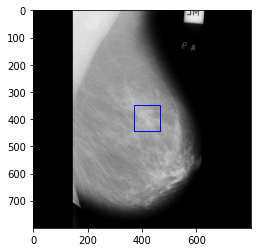

In [13]:
boundary_box_resize(train_re)

#2. Training

##2.1. VGG16 Model

In [14]:
from numpy.core.fromnumeric import shape

# VGG Network
def vgg16_cnn(df, h = 800, w = 800, c = 3):

  '''

  This function uses pre-trained vgg16 model to extract the feature map of the passed images. 

  Params: df with
  0: image path

  Returns: 
  - output model of vgg16
  - feature map
  - df with additional info:
  w_fm: width of the feature map
  h_fm: height of the feature map
  n_anchors: number of potential anchors per image

  '''

  # show execution time
  start_time = time.time()



  # --------------- vgg16 model -------------
   
  vgg16 = tf.keras.applications.VGG16(
    include_top=False,  # don't include last block of pre-trained vgg16 model
    weights='imagenet', # weights of imagenet
    input_shape = (w, h, c) # size of img
  )

  for layer in vgg16.layers:
    layer.trainable = True # trainable parameters
  
  vgg16_model = Model(inputs= [vgg16.layers[0].input], outputs= [vgg16.layers[17].output]) # last max pooling layer is out


  # train data
  train_images = []
  
  for i in df.iloc:
    img = cv2.imread(str(i[0]))
    train_images.append(img)

  train_images = np.array(train_images)
  train_images = train_images/255 # normalize images

  feature_map = vgg16_model.predict(train_images)


  # feature map
  anchors = []
  w_fms = []
  h_fms = []
  features = []

  for i in df.iloc:
    img = cv2.imread(str(i[0]))
    fm = vgg16_model.predict(np.expand_dims(img, 0))
    _, w_fm, h_fm, _ = fm.shape # feature map size
    n_anchor = w_fm * h_fm    # calculate number of anchors per image
    anchors.append(n_anchor)
    w_fms.append(w_fm)
    h_fms.append(h_fm)



  # add sizes of feature map in the df
  df['n_anchor'] = anchors
  df['w_fm'] = w_fms # width of feature map
  df['h_fm'] = h_fms # height of feature map



  print(f"\n------- Execution time: {(time.time() - start_time)/60:.2f} minutes -------\n")
  print('Number of anchors needed: ', n_anchor)
  print('\n', vgg16_model.summary())
  
  
  return df, vgg16_model, feature_map


In [15]:
train_re, vgg16_model, feature_map = vgg16_cnn(train_re)


------- Execution time: 7.92 minutes -------

Number of anchors needed:  2500
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 800, 800, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 800, 800, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 800, 800, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 400, 400, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 400, 400, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 400, 400, 128)     147584    
                                                

In [16]:
### CHECKPOINT - SAVE INTO DRIVE
train_re.to_csv("/content/archive/train_re.csv", sep = ";") # save file
!cp "/content/archive/train_re.csv" "/content/gdrive/MyDrive/99_Output"

In [17]:
### CHECKPOINT - SAVE INTO DRIVE
vgg16_model.save('/content/archive/vgg16_model.h5') # save model
!cp "/content/archive/vgg16_model.h5" "/content/gdrive/MyDrive/99_Output"

In [18]:
### CHECKPOINT - SAVE INTO DRIVE
np.save('/content/archive/feature_map', feature_map) # save file
!cp "/content/archive/feature_map.npy" "/content/gdrive/MyDrive/99_Output"

In [19]:
train_re = pd.read_csv("/content/gdrive/MyDrive/99_Output/train_re.csv", sep = ";")

In [20]:
train_re.head()

,Unnamed: 0,image path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm
0,0,/content/archive/all-mias/mdb239_resize.jpeg,423.43750,462.50000,149.21875,188.28125,CALC,2500,50,50
1,1,/content/archive/all-mias/mdb223_resize.jpeg,385.93750,431.25000,400.78125,446.09375,CALC,2500,50,50
2,2,/content/archive/all-mias/mdb270_resize.jpeg,221.87500,334.37500,5.46875,117.96875,CIRC,2500,50,50
3,3,/content/archive/all-mias/mdb160_resize.jpeg,371.09375,466.40625,346.87500,442.18750,ARCH,2500,50,50
4,4,/content/archive/all-mias/mdb226_resize.jpeg,408.59375,421.09375,230.46875,242.96875,CALC,2500,50,50


##2.2. Anchor points

In [22]:
def anchor_points (df, w = 800, h = 800):

    '''
    
    This function plots an indicated image with its possible anchor boxes and adds the centre of coordinates x and y into columns in df.


    Params: df with:
    1: image path
    2: min x coord
    3: max x coord
    4: min y coord
    5: max y coord
    6: class
    7: number of anchors
    8: feature map width
    9: feature map height

    width and height of . default at 800

    Output: plot of random image with possible anchors and df with additional info:
    - Number of possible anchors per image (n_anchors)
    - width of feature map (w_fm)
    - height of feature map (h_fm)
    - centre_list: list with (x,y) anchor points of the image
    
    '''


    # -------- calculate the centre of anchor image for all images --------

    centre_lists, x_strs, y_strs = [], [], []

    for i in df.iloc:
      img_path = i[1]
      
      x = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,8]
      x_str = int(w / int(x.values[0]))
      y = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,9]
      y_str = int(h / int(y.values[0]))
      
      # centre anchor image
      x_centre = np.arange(8, w, x_str) 
      y_centre = np.arange(8, h, y_str)
      centre_list = np.array(np.meshgrid(x_centre, y_centre,  sparse=False, indexing='xy')).T.reshape(-1,2)

      centre_lists.append(centre_list)

    # add info to the df
    df['x_str'] = x_str
    df['y_str'] = y_str
    df['anchor_points'] = centre_lists



    # ------------- plot image -------------

    # take indicated image
    image = input("introduce image name: ") 
    img_path = '/content/archive/all-mias/{:}'.format(image)
    img_ = cv2.imread(img_path)
    
    centre_list_r1 = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,-1] # take the centre list from the indicated image
    centre_list_r1 = centre_list_r1.values[0]

    # plot anchor positions 
    plt.figure(figsize=(9, 6))
    

    a = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,7]
    b = a.values[0]
    for i in range(b):
      cv2.circle(img_, (int(centre_list_r1[i][0]), int(centre_list_r1[i][1])), radius=1, color=(255, 0, 0), thickness=5) 
      
    
    plt.imshow(img_)
    plt.show()


    return df

introduce image name: mdb160_resize.jpeg


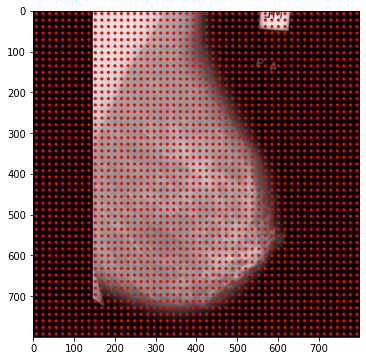

,Unnamed: 0,image path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm,x_str,y_str,anchor_points
0,0,/content/archive/all-mias/mdb239_resize.jpeg,423.437500,462.500000,149.218750,188.281250,CALC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [..."
1,1,/content/archive/all-mias/mdb223_resize.jpeg,385.937500,431.250000,400.781250,446.093750,CALC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [..."
2,2,/content/archive/all-mias/mdb270_resize.jpeg,221.875000,334.375000,5.468750,117.968750,CIRC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [..."
3,3,/content/archive/all-mias/mdb160_resize.jpeg,371.093750,466.406250,346.875000,442.187500,ARCH,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [..."
4,4,/content/archive/all-mias/mdb226_resize.jpeg,408.593750,421.093750,230.468750,242.968750,CALC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,493,/content/archive/all-mias/mdb181_hflip_resize....,337.500000,376.562500,337.500000,376.562500,SPIC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [..."
494,494,/content/archive/all-mias/mdb181_noise_resize....,363.281250,447.656250,475.000000,559.375000,SPIC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [..."
495,495,/content/archive/all-mias/mdb181_rotate_resize...,-4.929118,246.977673,-4.929118,246.977673,SPIC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [..."
496,496,/content/archive/all-mias/mdb181_vflip_resize....,371.093750,466.406250,371.093750,466.406250,SPIC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [..."


In [23]:
anchor_points(train_re)

In [24]:
# double check
shape(train_re.iloc[:,-1][0])

(2500, 2)

##2.3. Anchor boxes

In [25]:
def anchor_boxes (df, w= 800, h = 800):

    
  ''' This function calculates the anchor boxes per image and plots one random image. It additionally adds the anchor boxes in an array.
  
  Params: 
  
  - df with:
  1: image path
  2: min x coord
  3: max x coord
  4: min y coord
  5: max y coord
  6: class
  7: number of anchors
  8: feature map of width
  9: feature map height
  10: anchor centre of fm, x coord
  11: anchor centre of fm, y coord
  12: list of centre coords in img (x,y)

  width and height. default at 800

  Output: plot of random image with 9 anchor boxes at the middle of the centre anchor and df with additional info:
  - possible anchor boxes per image with xmin, ymin, xmax, ymax
  - possible anchor boxes per image with x, y, w, h
    
  '''

    
  # ------------- calculate anchor boxes per image -------------

  l = []
        
  # aspect ratio width and height
  anchor_ratio_l = [0.5, 1, 2] # 3 scenarios: vertical rect (width is half height), square (width = height), horizontal rect (width is twice hight)
  anchor_scale_l = [8, 16, 32] # anchor box area, according to original paper [128, 256, 512] in original paper


  total_anchors = []
  n_objects = []
  anchors_list, anchors_lists = [], []
  anchors_list_cent, anchors_lists_cent = [], []

  # rpn is passed into conv. layer with 3x3 filters
  for i in df.iloc:
    n_anchors = i[7] * len(anchor_ratio_l) * len(anchor_scale_l) # number of possible anchors
    total_anchors.append(n_anchors)
    bbox_list = np.array([i[2], i[4], i[3], i[5]]) # boundary box in np
    n_object = len(bbox_list) # number of objects in the image
    n_objects.append(n_object)
    # there are a total of 2500 anchor centres per image, each anchor centre has 9 anchor boxes
    # total number of anchor boxes in feature map will be 2500 * 9 = 22500, and each anchor box is denoted by 4 numbers
    anchor_list = np.zeros(shape= (n_anchors, 4))
    anchor_list_cent = np.zeros(shape= (n_anchors, 4))
          
    count = 0
    centre_list_ = i[-1]
    x_str = i[-3]
    y_str = i[-2]

    # for each anchor point
    for centre in centre_list_:
      centre_x, centre_y = centre[0], centre[1]
      # for each ratio
      for ratio in anchor_ratio_l:
        # for each scale
        for scale in anchor_scale_l:
        # compute height and width and scale them by constant factor
          h = pow(pow(scale, 2)/ ratio, 0.5)
          w = h * ratio

          # scale h and w
          h *= x_str
          w *= y_str


          # * at this point we have height and width of anchor and centers of anchor locations
          # putting anchor 9 boxes at each anchor locations (3x3 filters)
          anchor_xmin = centre_x - 0.5 * w
          anchor_xmax = centre_x + 0.5 * w
          anchor_ymin = centre_y - 0.5 * h
          anchor_ymax = centre_y + 0.5 * h
          l.append([centre_x, centre_y, w, h])     
          
          # append the anchor box to anchor list
          anchor_list[count] = [anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax]
          # append the anchor box with centre coord to anchor list
          anchor_list_cent[count] = [centre_x, centre_y, w, h]
                
          count += 1

    anchors_lists.append(anchor_list)      
    anchors_lists_cent.append(anchor_list_cent)
      
  # add values to the df
  df['n_possible_anchors'] = total_anchors
  df['n_object'] = n_objects
  df['possible_anchors'] = anchors_lists
  df['possible_anchors_cent'] = anchors_lists_cent


  
  # ------------ visualize anchor boxes at center anchor location of an indicated image

  # take indicated image
  image = input("introduce image name: ") 
  img_path = '/content/archive/all-mias/{:}'.format(image)
  img_ = cv2.imread(img_path)

  centre_list_r2 = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,12] # take the centre list from the indicated image
  centre_list_r2 = centre_list_r2.values[0]


  # mid anchor centre = 2500/2 = 1250
  anchor = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,7]
  anchor = anchor.values[0]
  range1 = int(round(anchor/2 * 9, 0))


  for i in range(11025, 11025+9):  # 1250 * 9 = 11025 (9 anchors corresponds to mid anchor center)
    x_min = int(anchor_list[i][0])
    y_min = int(anchor_list[i][1])
    x_max = int(anchor_list[i][2])
    y_max = int(anchor_list[i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

  bbox_lists = []
  for i in df.iloc:
    bbox_list = np.array([i[2], i[4], i[3], i[5]])
    bbox_lists.append(bbox_list)

  df['bbox_list'] = bbox_lists


  ground_truth = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,-1]
  ground_truth = ground_truth.values[0]

  cv2.rectangle(img_, (int(ground_truth[0]), int(ground_truth[1])), (int(ground_truth[2]), int(ground_truth[3])), color=(0, 0, 255), thickness=3)       
  
  cv2.circle(img_, (int(centre_list_r2[312][0]), int(centre_list_r2[312][1])), radius=1, color=(0, 255, 0), thickness=15) 

  plt.imshow(img_)
  plt.show()


  return df

introduce image name: mdb160_resize.jpeg


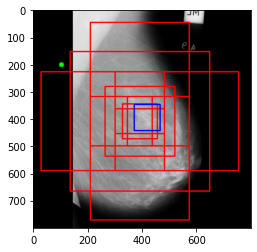

,Unnamed: 0,image path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm,x_str,y_str,anchor_points,n_possible_anchors,n_object,possible_anchors,possible_anchors_cent,bbox_list
0,0,/content/archive/all-mias/mdb239_resize.jpeg,423.437500,462.500000,149.218750,188.281250,CALC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[423.4375, 149.21875, 462.5, 188.28125]"
1,1,/content/archive/all-mias/mdb223_resize.jpeg,385.937500,431.250000,400.781250,446.093750,CALC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[385.9375, 400.78125, 431.25, 446.09375]"
2,2,/content/archive/all-mias/mdb270_resize.jpeg,221.875000,334.375000,5.468750,117.968750,CIRC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[221.875, 5.46875, 334.375, 117.96875]"
3,3,/content/archive/all-mias/mdb160_resize.jpeg,371.093750,466.406250,346.875000,442.187500,ARCH,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[371.09375, 346.875, 466.40625, 442.1875]"
4,4,/content/archive/all-mias/mdb226_resize.jpeg,408.593750,421.093750,230.468750,242.968750,CALC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[408.59375, 230.46875, 421.09375, 242.96875]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,493,/content/archive/all-mias/mdb181_hflip_resize....,337.500000,376.562500,337.500000,376.562500,SPIC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[337.5, 337.5, 376.5625, 376.5625]"
494,494,/content/archive/all-mias/mdb181_noise_resize....,363.281250,447.656250,475.000000,559.375000,SPIC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[363.28125, 475.0, 447.65625, 559.375]"
495,495,/content/archive/all-mias/mdb181_rotate_resize...,-4.929118,246.977673,-4.929118,246.977673,SPIC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[-4.92911766385884, -4.92911766385884, 246.977..."
496,496,/content/archive/all-mias/mdb181_vflip_resize....,371.093750,466.406250,371.093750,466.406250,SPIC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[371.09375, 371.09375, 466.40625, 466.40625]"


In [26]:
anchor_boxes(train_re)

##2.4. Intersection over union - anchor boxes to ground truth

In [27]:
def IoU_faster_rcnn (df, threshold = 0.5):
    
    '''

    Calculate Intersection of Union (IoU) between anchor box and ground truth. 

    Params: df containing info on images
    1: image path
    2: x min coord
    3: x max coord
    4: y min coord
    5: y max coord
    6: label
    7: number of anchors
    8: width feature map
    9: height feature map
    10: centre x
    11: centre y
    12: centre list
    13: number of possible anchors
    14: number of objects
    15: anchor: predicted anchors in arrays. Sorted by xmax, ymax, xmin, ymin
    16: anchor: predicted anchors in arrays. Sorted by x, y, w, h
    17: boundary box: ground truth in array. Sorted by xmax, ymax, xmin, ymin

    Returns: An additional column in passed df with a list of arrays with the obtained IoUs: one IoU value per anchor box. 
    
    '''
    

    
    # ------calculate coordinate of overlapping region------

    truths = df.iloc[:,17]
    anchors = df.iloc[:,15]

    ious, labels = [], []

    for i in range(len(df)):
      
      ious_, labels_ = [], []
      
      for anchor in anchors[0]: # all images are of the same size, meaning anchor list is the same

        # take max of x1 and y1 out of both boxes
        x1 = max(truths[i][0], anchor[0])
        y1 = max(truths[i][1], anchor[1])
        # take min of x2 and y2 out of both boxes
        x2 = min(truths[i][2], anchor[2])
        y2 = min(truths[i][3], anchor[3])
        
          
        # ------area of overlapping region------
        if (x2 < x1 and y2 < y1): # if they don't overlap at all
          area_overlap =  0
        else:
          width_overlap = (x2 - x1)
          height_overlap = (y2 - y1)
          area_overlap = width_overlap * height_overlap

          
        # ------computing union------
        # sum of area of both the boxes - area_overlap
            
        # height and width of both boxes
        width_truth = (truths[i][2] - truths[i][0])
        height_truth = (truths[i][3] - truths[i][1])

        width_anchor = (anchor[2] - anchor[0])
        height_anchor = (anchor[3] - anchor[1])
            
        # area of box1 and box2
        area_truth = width_truth * height_truth
        area_anchor = width_anchor * height_anchor
            
        # union (including 2 * overlap area (double count))
        area_union_overlap = area_truth + area_anchor
            
        # union
        area_union = area_union_overlap - area_overlap
            
        # compute IOU
        iou = area_overlap/ area_union
        if iou < 0:
          ious_.append(0)
        else:
          ious_.append(iou)
        

        # ---------- add labels wrt iou value ---------

        if iou >= threshold:
          labels_.append(1)
        else:
          labels_.append(0)
        


      labels.append(labels_)
      ious.append(ious_)

    
    df['iou'] = ious
    df['labels_anchors'] = labels



    return df

In [28]:
IoU_faster_rcnn(train_re)

,Unnamed: 0,image path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm,x_str,y_str,anchor_points,n_possible_anchors,n_object,possible_anchors,possible_anchors_cent,bbox_list,iou,labels_anchors
0,0,/content/archive/all-mias/mdb239_resize.jpeg,423.437500,462.500000,149.218750,188.281250,CALC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[423.4375, 149.21875, 462.5, 188.28125]","[0.0, 0, 0, 0.0, 0.0, 0, 0.0, 0.0, 0, 0.0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,/content/archive/all-mias/mdb223_resize.jpeg,385.937500,431.250000,400.781250,446.093750,CALC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[385.9375, 400.78125, 431.25, 446.09375]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,/content/archive/all-mias/mdb270_resize.jpeg,221.875000,334.375000,5.468750,117.968750,CIRC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[221.875, 5.46875, 334.375, 117.96875]","[0, 0, 0, 0, 0, 0.017548106574922027, 0, 0, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,/content/archive/all-mias/mdb160_resize.jpeg,371.093750,466.406250,346.875000,442.187500,ARCH,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[371.09375, 346.875, 466.40625, 442.1875]","[0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,/content/archive/all-mias/mdb226_resize.jpeg,408.593750,421.093750,230.468750,242.968750,CALC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[408.59375, 230.46875, 421.09375, 242.96875]","[0.0, 0.0, 0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,493,/content/archive/all-mias/mdb181_hflip_resize....,337.500000,376.562500,337.500000,376.562500,SPIC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[337.5, 337.5, 376.5625, 376.5625]","[0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
494,494,/content/archive/all-mias/mdb181_noise_resize....,363.281250,447.656250,475.000000,559.375000,SPIC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[363.28125, 475.0, 447.65625, 559.375]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
495,495,/content/archive/all-mias/mdb181_rotate_resize...,-4.929118,246.977673,-4.929118,246.977673,SPIC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[-4.92911766385884, -4.92911766385884, 246.977...","[0.08152626782286425, 0.18416932332685065, 0.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
496,496,/content/archive/all-mias/mdb181_vflip_resize....,371.093750,466.406250,371.093750,466.406250,SPIC,2500,50,50,16,16,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[3

##2.5. Balancing anchor labels

As most of the anchors will be background (BG - label 0), results would be biased. Therefore, we need to take the same amount of anchors from foreground (FG) and BG.

In [29]:
def sample_anchors_pre(df, n_samples= 256, neg_ratio= 0.5):
    
    '''
    
    Sample total of n samples across both BG and FG classes.
    If one of the classes have less samples than n/2, we will sample from majority class to make up for short.

    Args:
    df with column named labels_anchors, containing 1 for foreground and 0 for background
    n_samples: number of samples to take in total. default 256, so 128 BG and 128 FG.
    neg_ratio: 1/2
    
    '''

    n_fg = int((1-neg_ratio) * n_samples)
    n_bg = int(neg_ratio * n_samples)
    fg_list = [x for x in df['labels_anchors'] if x == 1]
    bg_list = [x for x in df['labels_anchors'] if x == 0]

    # check if we have excessive positive samples
    if len(fg_list) > n_fg:
        # mark excessive samples as -1 (ignore)
        ignore_index = fg_list[n_bg:]
        df.loc[ignore_index, "labels_anchors"] = -1

    # sample background examples if we don't have enough positive examples to match the anchor batch size
    if len(fg_list) < n_fg:
        diff = n_fg - len(fg_list)
        # add remaining to background examples
        n_bg += diff

    # check if we have excessive background samples
    if len(bg_list) > n_bg:
        # mark excessive samples as -1 (ignore)
        ignore_index = fg_list[n_bg:]
        df.loc[ignore_index, "labels_anchors"] = -1

In [30]:
sample_anchors_pre(train_re)

## 2.6. Coordinates and labels

In order to train RPN and adjust our anchor boxes closer to the ground truth, we need to pass an array with the coordinates (x,y,w,h) and labels.

In [31]:
def coord_labels (df):

  '''

  This function obtains an array with the coordinates of possible anchor boxes and its labels.

  Args: df containing:

  1: image path
  2: xmin coord
  3: ymin coord
  4: xmax coord
  5: ymax coord
  16: array with anchors in order x,y,w,h
  17: ground truths
  18: iou
  19: labels

  Returns: 
    array with shape (x, 22500, 4), where x corresponds to the number of instances (aka images) the df contains.

  '''

  coords = np.array(df.iloc[:,16])
  labels = np.array(df.iloc[:,19])
  offset_list = np.zeros((len(df.iloc[:,16]), len(df.iloc[:,16].values[0]), len(df.iloc[:,16].values[0][0]))) # generate empty np with shape 
                                                                                                              # (x, 22500, 4)
  label_list = np.zeros((len(df.iloc[:,19]), len(df.iloc[:,19].values[0]), 1))
  
  # replace null values with anchor values
  layer1 = 0
  for i in coords:
    layer2 = 0
    for z in i:
      offset_list[layer1, layer2, :] = z
      
      layer2 += 1

    layer1 += 1

  
  # repeat process for labels
  layer1 = 0
  for i in labels:
    layer2 = 0
    for z in i:
      label_list[layer1, layer2, :] = z

      layer2 += 1
    
    layer1 += 1


  return offset_list, label_list

In [32]:
offset_list, label_list = coord_labels(train_re) # obtain the offset and label list

In [33]:
offset_list.shape, label_list.shape # check shapes are indeed correct

((498, 22500, 4), (498, 22500, 1))

In [34]:
# combine deltas and objectiveness score in one array
offset_list_label_list = np.zeros((498, 22500, 5))

layer1 = 0
for i in offset_list:
  for z in label_list:
    offset_list_label_list[layer1, :] = np.column_stack((i, z))[np.newaxis,:]
  
  layer1 +=1

print(offset_list_label_list.shape)

(498, 22500, 5)


##2.7. Regional Proposal Network 

In [35]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

def rpn (base_layer, w = 50, h = 50, c = 512):

  '''

  This function calculates the scores of each anchor box, as well as the deltas 

  '''

  # show execution time
  start_time = time.time()


  input_img = Input(shape = (w, h, c))
  
  #vgg16 = base_layer(input_img, training = True)
  
  x = Conv2D(512, kernel_size = (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(input_img) # conv layer with filter 3x3

  x_deltas = Conv2D(9 * 4, kernel_size = (1, 1), activation='linear',  
                                        kernel_initializer='zero', name='rpn_out_regress')(x) # conv layer for regression

  x_scores = Conv2D(9 * 1, kernel_size = (1, 1), activation='sigmoid', ## 9 * 1, FG (and BG)
                   kernel_initializer='uniform', name='rpn_out_score')(x) # conv layer for classification (whether the box is an object (FG) or background (BG))
  

  
  model = Model(inputs = [input_img] , outputs = [x_deltas, x_scores])
  
  model.summary()

  
  def smooth_l1_loss(y_true, y_pred):
    
    '''
    
    Calculates Smooth L1 loss
    
    '''

    # Take absolute difference
    x = K.abs(y_true - y_pred)

    # Find indices of values less than 1
    mask = K.cast(K.less(x, 1.0), "float32")
    # Loss calculation for smooth l1
    loss = (mask * (0.5 * x ** 2)) + (1 - mask) * (x - 0.5)
    return loss


  def custom_l1_loss(y_true, y_pred):
    
    '''

    Regress anchor offsets (deltas): only consider FG boxes
    
    '''

    offset_list= y_true[:,:,:-1]
    label_list = y_true[:,:,-1]
    
    # reshape output by the model
    y_pred = tf.reshape(y_pred, shape= (-1, 22500, 4))

    positive_idxs = tf.where(K.equal(label_list, 1)) # select only foreground boxes

    # Select positive predicted bbox shifts
    bbox = tf.gather_nd(y_pred, positive_idxs)
    
    target_bbox = tf.gather_nd(offset_list, positive_idxs)
    loss = smooth_l1_loss(target_bbox, bbox)

    return K.mean(loss)


  def custom_binary_loss(y_true, y_pred_objectiveness):
    
    '''
    
    Select both FG and BG class and compute cross entropy
    
    '''
    
    y_pred = tf.reshape(y_pred_objectiveness, shape= (-1, 22500))
    y_true = tf.squeeze(y_true, -1)
    
    # Find indices of positive and negative anchors, not neutral
    indices = tf.where(K.not_equal(y_true, -1)) # ignore -1 labels

    # Pick rows that contribute to the loss and filter out the rest.
    rpn_match_logits = tf.gather_nd(y_pred, indices)
    anchor_class = tf.gather_nd(y_true, indices)
    
    
    # Cross entropy loss
    loss = K.binary_crossentropy(target=anchor_class,
                                output=rpn_match_logits
                                )
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    
    return loss



  optimizer = Adam(learning_rate=1e-5)
  
  model.compile(optimizer=optimizer, loss=[custom_l1_loss, custom_binary_loss], run_eagerly=True) # use computed losses
  

  print(f"\n------- Execution time: {(time.time() - start_time)/60:.2f} minutes -------\n")

  return model, x_deltas, x_scores

In [36]:
rpn_model, x_deltas, x_scores = rpn(vgg16_model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 512  0           []                               
                                )]                                                                
                                                                                                  
 rpn_conv1 (Conv2D)             (None, 50, 50, 512)  2359808     ['input_2[0][0]']                
                                                                                                  
 rpn_out_regress (Conv2D)       (None, 50, 50, 36)   18468       ['rpn_conv1[0][0]']              
                                                                                                  
 rpn_out_score (Conv2D)         (None, 50, 50, 9)    4617        ['rpn_conv1[0][0]']        

In [37]:
label_list.shape, offset_list_label_list.shape, feature_map.shape

((498, 22500, 1), (498, 22500, 5), (498, 50, 50, 512))

In [38]:
rpn_hist = rpn_model.fit(feature_map,[offset_list_label_list, label_list], epochs= 100)

Epoch 1/100
16/16 [==============================] - 34s 2s/step - loss: nan - rpn_out_regress_loss: nan - rpn_out_score_loss: 0.6671
Epoch 2/100
16/16 [==============================] - 38s 2s/step - loss: nan - rpn_out_regress_loss: nan - rpn_out_score_loss: 0.5905
Epoch 3/100
16/16 [==============================] - 38s 2s/step - loss: nan - rpn_out_regress_loss: nan - rpn_out_score_loss: 0.5217
Epoch 4/100
16/16 [==============================] - 38s 2s/step - loss: nan - rpn_out_regress_loss: nan - rpn_out_score_loss: 0.4604
Epoch 5/100
16/16 [==============================] - 38s 2s/step - loss: nan - rpn_out_regress_loss: nan - rpn_out_score_loss: 0.4060
Epoch 6/100
16/16 [==============================] - 38s 2s/step - loss: nan - rpn_out_regress_loss: nan - rpn_out_score_loss: 0.3580
Epoch 7/100
16/16 [==============================] - 41s 3s/step - loss: nan - rpn_out_regress_loss: nan - rpn_out_score_loss: 0.3156
Epoch 8/100
16/16 [==============================] - 41s 3s/st

In [39]:
### CHECKPOINT - SAVE INTO DRIVE
rpn_model.save('/content/archive/rpn_model_vgg16.h5') # save model
!cp "/content/archive/rpn_model_vgg16.h5" "/content/gdrive/MyDrive/99_Output"

In [40]:
print(rpn_hist.history.keys())

dict_keys(['loss', 'rpn_out_regress_loss', 'rpn_out_score_loss'])


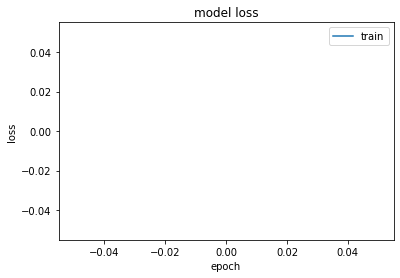

In [41]:
plt.plot(rpn_hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

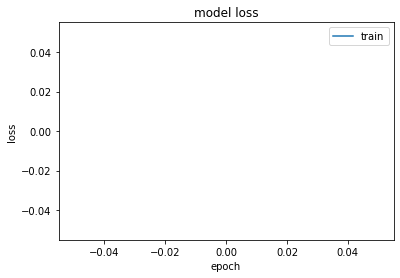

In [42]:
plt.plot(rpn_hist.history['rpn_out_regress_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

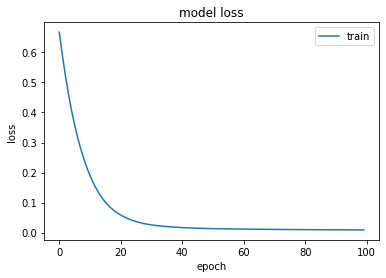

In [43]:
plt.plot(rpn_hist.history['rpn_out_score_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [44]:
# get the offset and objectiveness score
pred_x_deltas, pred_x_scores = rpn_model.predict(feature_map)


# shape both predictions
n_anchors = 22500
pred_x_deltas = pred_x_deltas.reshape(-1, n_anchors, 4) 
pred_x_scores = pred_x_scores.reshape(-1, n_anchors)

In [45]:
#### CHECKPOINT
# save results into the system
np.save('/content/archive/pred_x_scores', pred_x_scores) # save file
!cp "/content/archive/pred_x_scores.npy" "/content/gdrive/MyDrive/99_Output"

np.save('/content/archive/pred_x_deltas', pred_x_deltas) # save file
!cp "/content/archive/pred_x_deltas.npy" "/content/gdrive/MyDrive/99_Output"

In [46]:
# import
pred_x_deltas = np.load('/content/gdrive/MyDrive/99_Output/pred_x_deltas.npy')
pred_x_scores = np.load('/content/gdrive/MyDrive/99_Output/pred_x_scores.npy')

In [47]:
# parse anchor deltas
dx = pred_x_deltas[:, :, 0]
dy = pred_x_deltas[:, :, 1]
dw = pred_x_deltas[:, :, 2]
dh = pred_x_deltas[:, :, 3]

print(pred_x_deltas.shape, pred_x_scores.shape)

(498, 22500, 4) (498, 22500)


##2.8. Regions of interest

Now that we have deltas and scores for each anchor box, we will adjust each anchor box based on the deltas. Furthermore, the proposal boxes will be clipped to the image and proposals will be sorted according to the objectivenes score.  

In [50]:
def rpn_to_roi (df, x_scores, dx, dy, dw, dh, threshold = 1):

  '''

  This function obtains the regional proposals (roi) based on the anchor boxes and the deltas obtained from the regional proposal network.

  Args: scores and deltas (dx, dw, dw, dh) and threshold, which will be used to eliminate anchor boxes exceeding it.

  df with:
  15: anchor boxes with xmin, xmax, ymin, ymax
  16: anchor boxes with x,y,w,h

  Returns:
  Roi in format x_min, y_min, x_max, y_max

  '''

  anchors_list = df.iloc[:,16]

  A = np.zeros((len(df), len(anchors_list[0]), 4)) # all images have the same anchors_list length (22500)
  
  layer1 = 0
  for anchors in anchors_list:
    layer2 = 0
    for x in anchors:
      anchor_centre_x = x[0]
      anchor_centre_y = x[1]
      anchor_width = x[2]
      anchor_height = x[3]

      # --------- adjust anchor boxes with predicetd offset-----------
      centre_x = dx[layer1][layer2] * anchor_width + anchor_centre_x
      centre_y = dy[layer1][layer2] *  anchor_height + anchor_centre_y
      width = np.exp(dw[layer1][layer2]) * anchor_width
      height = np.exp(dh[layer1][layer2]) * anchor_height

      # -------- conver them to min and max values -------------------
      x_min = centre_x - 0.5 * width
      y_min = centre_y - 0.5 * height
      x_max = centre_x + 0.5 * width
      y_max = centre_y + 0.5 * height

      # -------- add them to the empty array--------------------------
      A[layer1, layer2, :] = [x_min, y_min, x_max, y_max]

      layer2 +=1
    
    layer1 +=1


  A = A.T # transpose result

  
  roi  = np.clip(A, 0, 800) # clipping results to image size

  roi = roi.T # transpose result


  # ------- sort roi ascending order --------
  scores_sorted = np.zeros((498, 22500)) # 22500 scores per image
  rois_sorted = np.zeros((498, 22500, 4))
  sorted_idxs = np.zeros((498, 22500)) # 22500 indexes per image

  l = 0
  for img in (roi):
      img = np.int64(img)
      score = pred_x_scores[l]
      sorted_idx = score.flatten().argsort()[::1] # generate ascending index
      score_sorted = score[sorted_idx] # sort the predicted scores
      roi_sorted = img[sorted_idx]

      rois_sorted[l, :] = roi_sorted
      scores_sorted[l, :] = score_sorted
      sorted_idxs[l, :] = sorted_idx.T

      l +=1


  return roi, scores_sorted, rois_sorted, sorted_idxs

In [51]:
roi, scores_sorted, rois_sorted, sorted_idxs = rpn_to_roi(train_re, pred_x_scores, dx, dy, dw, dh)

In [52]:
# check output shape
roi.shape, scores_sorted.shape, rois_sorted.shape, sorted_idxs.shape

((498, 22500, 4), (498, 22500), (498, 22500, 4), (498, 22500))

##2.9. Non-maximum suppression

In [53]:
def non_max_suppression_fast(roi_sorted, score_sorted, pre_NMS_topN = 12000, threshold=0.7, n_train_post_nms = 2000):

  '''

  This function filters top N anchor boxes (ROI), eliminates highly overlapping ROIs and selects "n_train_post_nms" filtered proposals.

  Args: list of rois in 3D, scores in 2D.

  Returns: rois filtered with corresponding scores.

  '''
  
  roi_sorted_filtered, score_sorted_filtered = [], [] # generate empty lists to append results

  for img, score in zip(roi_sorted, score_sorted): # for each img
    # coordinates of the roi boxes
    x1 = img[:, 0]
    y1 = img[:, 1]
    x2 = img[:, 2]
    y2 = img[:, 3]
    
    # area of all roi
    # + 1 to prevent division by zero
    width_list = (x2 - x1) + 1 
    height_list = (y2 - y1) + 1
    area =  width_list * height_list

    # initialize the list of keep indexes	
    keep = []

    # generate np array from top selected rois
    roi_idx = np.array(range(pre_NMS_topN))
    # total number of ROIs to select after NMS
    n_train_post_nms = n_train_post_nms


    # keep looping while some indexes still remain in the indexes
    # list
    while roi_idx.size > 0:
        current_id = roi_idx[0]

        # add the current rio id to keep list
        keep.append(current_id)
        

        # find the intersection
        xx1 = np.maximum(x1[current_id], x1[roi_idx[1:]]) # maximum of x1 of current and all other x1 roi
        yy1 = np.maximum(y1[current_id], y1[roi_idx[1:]])
        xx2 = np.minimum(x2[current_id], x2[roi_idx[1:]])
        yy2 = np.minimum(y2[current_id], y2[roi_idx[1:]])

        ww = np.maximum(0., xx2 - xx1 +1)
        hh = np.maximum(0., yy2 - yy1 +1)

        inter = ww * hh

        # iou
        iou = inter/ (area[current_id] + area[roi_idx[1:]] - inter)

        # select boxes whose overlap is less than the threshold
        keep_idx = np.where(iou <= threshold)[0]
        
        # update the ROI index list(* note +1 to the indices list)
        roi_idx = roi_idx[keep_idx + 1]

    # select only "top n_train_post_nms" proposals (2000)
    keep = keep[: n_train_post_nms]

    img = img[keep]
    score = score[keep]
        
    roi_sorted_filtered.append(img)
    score_sorted_filtered.append(score)
    
  return roi_sorted_filtered, score_sorted_filtered

In [54]:
roi_sorted_filtered, score_sorted_filtered = non_max_suppression_fast(rois_sorted, scores_sorted)

In [55]:
# convert to np.array
roi_sorted_filter = np.array(roi_sorted_filtered)
score_sorted_filter = np.array(score_sorted_filtered)

# check shapes
print(roi_sorted_filter.shape, score_sorted_filter.shape)

(498,) (498,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
# append results in our df
train_re['roi_filter'] = roi_sorted_filter
train_re['score_filter'] = score_sorted_filter

train_re.head(3) # check output

,Unnamed: 0,image path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm,...,anchor_points,n_possible_anchors,n_object,possible_anchors,possible_anchors_cent,bbox_list,iou,labels_anchors,roi_filter,score_filter
0,0,/content/archive/all-mias/mdb239_resize.jpeg,423.4375,462.500,149.21875,188.28125,CALC,2500,50,50,...,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[423.4375, 149.21875, 462.5, 188.28125]","[0.0, 0, 0, 0.0, 0.0, 0, 0.0, 0.0, 0, 0.0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[218.0, 221.0, 309.0, 402.0], [0.0, 130.0, 62...","[7.4552290243445896e-06, 8.232473192038015e-06..."
1,1,/content/archive/all-mias/mdb223_resize.jpeg,385.9375,431.250,400.78125,446.09375,CALC,2500,50,50,...,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[385.9375, 400.78125, 431.25, 446.09375]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[42.0, 349.0, 133.0, 530.0], [58.0, 365.0, 14...","[2.323146691196598e-05, 2.4842069251462817e-05..."
2,2,/content/archive/all-mias/mdb270_resize.jpeg,221.8750,334.375,5.46875,117.96875,CIRC,2500,50,50,...,"[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...",22500,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[221.875, 5.46875, 334.375, 117.96875]","[0, 0, 0, 0, 0, 0.017548106574922027, 0, 0, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.0, 274.0, 594.0, 637.0], [186.0, 365.0, 27...","[1.3910719644627534e-05, 1.6466899978695437e-0..."


##2.10. Intersection over union (IoU)

After getting top anchor boxes, we assign each anchor box a 1 (FG) or 0 (BG) labels based on the IoU:


*   1 if IoU > 0.5
*   0 if 0.1 < IoU < 0.5



In [57]:
def IoU_ROI (df, pos_threshold = 0.5, neg_threshold = 0.1):
    
    '''

    Calculate Intersection of Union (IoU) between ROI and ground truth. 

    Params: df containing info on images
    1: image path
    2: x min coord
    3: x max coord
    4: y min coord
    5: y max coord
    6: label
    7: number of anchors
    8: width feature map
    9: height feature map
    10: centre x
    11: centre y
    12: centre list
    13: number of possible anchors
    14: number of objects
    15: anchor: predicted anchors in arrays. Sorted by xmax, ymax, xmin, ymin
    16: anchor centre: predicted anchors in arrays. Sorted by x, y, w, h
    17: bbox: ground truth in array. Sorted by xmax, ymax, xmin, ymin
    18: iou between predicted anchors and ground truth
    19: labels based on iou in column 18
    20: roi filtered by top N values
    21: score per roi filtered by top N values

    max_iou: boundary of IOU: 50% by default
    min_iou: min. boundary for IOU: 10% by default

    Returns: An additional column in passed df with a list of arrays with the obtained IoUs. An extra column with the avg IoU per image
    and it also prints the avg IoU of the model.
    
    '''
    

    
    # ------calculate coordinate of overlapping region------

    truths = df.iloc[:,17]
    rois = df.iloc[:,20]

    ious, idx_pos, idx_neg = [], [], []

    for i in range(len(df)):
      
      ious_, idx_pos_, idx_neg_ = [], [], []
      idx = 0 # initate index
      
      for roi in rois[i]:
        
        # take max of x1 and y1 out of both boxes
        x1 = max(truths[i][0], roi[0])
        y1 = max(truths[i][1], roi[1])
        # take min of x2 and y2 out of both boxes
        x2 = min(truths[i][2], roi[2])
        y2 = min(truths[i][3], roi[3])
        
          
        # ------area of overlapping region------
        if (x2 < x1 and y2 < y1): # if they don't overlap at all
          area_overlap =  0
        else:
          width_overlap = (x2 - x1)
          height_overlap = (y2 - y1)
          area_overlap = width_overlap * height_overlap

          
        # ------computing union------
        # sum of area of both the boxes - area_overlap
            
        # height and width of both boxes
        width_truth = (truths[i][2] - truths[i][0])
        height_truth = (truths[i][3] - truths[i][1])

        width_roi = (roi[2] - roi[0])
        height_roi = (roi[3] - roi[1])
            
        # area of box1 and box2
        area_truth = width_truth * height_truth
        area_roi = width_roi * height_roi
            
        # union (including 2 * overlap area (double count))
        area_union_overlap = area_truth + area_roi
            
        # union
        area_union = area_union_overlap - area_overlap
            
        # compute IOU
        iou = area_overlap/ area_union

        # select proposals whose IOU is > or = max_iou
        # add an index
        if iou >= pos_threshold:
          #ious_.append(iou)
          idx_pos_.append(idx)
        # select proposals whose IOU is < max_iou but > max_iou
        # add index for negative iou
        elif (iou < pos_threshold and iou >= neg_threshold):
          #ious_.append(iou)
          idx_neg_.append(idx)
        else:
          pass
        #print('idx: ', idx)
        #print('iou: ', iou)
        idx += 1

      #ious.append(ious_)
      idx_pos.append(idx_pos_)
      idx_neg.append(idx_neg_)

    #df['iou_roi'] = ious
    df['iou_idx_pos'] = idx_pos
    df['iou_idx_neg'] = idx_neg


    return df

In [58]:
IoU_ROI(train_re) # apply to our dataset

,Unnamed: 0,image path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm,...,n_object,possible_anchors,possible_anchors_cent,bbox_list,iou,labels_anchors,roi_filter,score_filter,iou_idx_pos,iou_idx_neg
0,0,/content/archive/all-mias/mdb239_resize.jpeg,423.437500,462.500000,149.218750,188.281250,CALC,2500,50,50,...,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[423.4375, 149.21875, 462.5, 188.28125]","[0.0, 0, 0, 0.0, 0.0, 0, 0.0, 0.0, 0, 0.0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[218.0, 221.0, 309.0, 402.0], [0.0, 130.0, 62...","[7.4552290243445896e-06, 8.232473192038015e-06...",[],[]
1,1,/content/archive/all-mias/mdb223_resize.jpeg,385.937500,431.250000,400.781250,446.093750,CALC,2500,50,50,...,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[385.9375, 400.78125, 431.25, 446.09375]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[42.0, 349.0, 133.0, 530.0], [58.0, 365.0, 14...","[2.323146691196598e-05, 2.4842069251462817e-05...",[],"[297, 366, 685, 819, 827, 870, 909, 925, 930, ..."
2,2,/content/archive/all-mias/mdb270_resize.jpeg,221.875000,334.375000,5.468750,117.968750,CIRC,2500,50,50,...,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[221.875, 5.46875, 334.375, 117.96875]","[0, 0, 0, 0, 0, 0.017548106574922027, 0, 0, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.0, 274.0, 594.0, 637.0], [186.0, 365.0, 27...","[1.3910719644627534e-05, 1.6466899978695437e-0...","[721, 851, 968, 1358, 1603, 1655, 1793, 1796]","[450, 647, 649, 653, 688, 712, 718, 729, 827, ..."
3,3,/content/archive/all-mias/mdb160_resize.jpeg,371.093750,466.406250,346.875000,442.187500,ARCH,2500,50,50,...,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[371.09375, 346.875, 466.40625, 442.1875]","[0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[74.0, 509.0, 165.0, 690.0], [0.0, 418.0, 482...","[1.694010825303849e-05, 1.891572719614487e-05,...","[392, 920, 1320, 1529, 1961]","[23, 48, 78, 80, 96, 104, 119, 122, 138, 142, ..."
4,4,/content/archive/all-mias/mdb226_resize.jpeg,408.593750,421.093750,230.468750,242.968750,CALC,2500,50,50,...,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[408.59375, 230.46875, 421.09375, 242.96875]","[0.0, 0.0, 0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[186.0, 349.0, 277.0, 530.0], [202.0, 365.0, ...","[1.5432560758199543e-05, 1.817895463318564e-05...",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,493,/content/archive/all-mias/mdb181_hflip_resize....,337.500000,376.562500,337.500000,376.562500,SPIC,2500,50,50,...,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[337.5, 337.5, 376.5625, 376.5625]","[0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[109.0, 306.0, 800.0, 669.0], [216.0, 232.0, ...","[2.146537917724345e-05, 2.6445834009791724e-05...",[],[]
494,494,/content/archive/all-mias/mdb181_noise_resize....,363.281250,447.656250,475.000000,559.375000,SPIC,2500,50,50,...,4,"[[-37.254833995939045, -82.50966799187809, 53....","[[8.0, 8.0, 90.50966799187809, 181.01933598375...","[363.28125, 475.0, 447.65625, 559.375]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[93.0, 130.0, 800.0, 493.0], [426.0, 221.0, 5...","[1.6145168046932667e-05, 1.6334624888258986e-0...",[],"[399, 405, 674, 795, 797, 881, 931, 942, 957, ..."
495,495,/content/archive/all-mias/mdb181_rotate_resize...,-4.929118,246.977673,-4.929118,246.977673,SPI

#3. Evaluation of the model

Evaluation of the model performance through mAP metric.

In [59]:
# select positive rois through the index
rois_pos = []
for i, z in zip(train_re['roi_filter'], train_re['iou_idx_pos']):
  roi_pos = i[z]
  rois_pos.append(roi_pos)

train_re['rois_pos'] = rois_pos

In [60]:
# check which image indexes actually have at least one roi with a positive label (iou > 0.5)
idx = 0
for i in train_re['rois_pos']:
  if len(i) > 0:
    print(idx)
  else:
    pass
  
  idx +=1

2
3
5
7
9
17
20
25
26
30
33
41
45
50
51
52
57
58
60
61
63
68
75
85
90
91
94
95
97
99
100
105
106
109
111
112
115
116
119
121
122
125
129
130
131
135
136
140
145
146
150
155
156
165
169
170
175
180
181
184
185
186
187
190
191
195
196
200
201
202
205
206
209
210
211
214
215
216
217
220
221
225
230
231
234
235
236
237
240
245
246
249
250
251
252
255
256
260
261
265
266
270
275
276
280
281
285
286
289
290
292
295
296
300
301
305
309
310
311
312
315
316
321
325
330
331
334
335
337
339
340
344
345
346
350
351
355
360
365
366
369
370
371
372
374
375
380
384
385
386
387
389
390
391
392
395
399
400
401
402
405
410
411
415
421
424
425
426
430
435
440
441
445
446
450
451
455
456
459
460
461
462
465
470
471
475
476
480
485
486
490
495
496


Let's plot one of the images with the ground truth and the predicted boxes.

In [64]:
# check information on image 75
train_re.iloc[75]

Unnamed: 0                                                              75
image path                    /content/archive/all-mias/mdb025_resize.jpeg
xmin                                                             464.84375
xmax                                                             588.28125
ymin                                                              392.1875
ymax                                                               515.625
labels                                                                CIRC
n_anchor                                                              2500
w_fm                                                                    50
h_fm                                                                    50
x_str                                                                   16
y_str                                                                   16
anchor_points            [[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [...
n_possible_anchors       

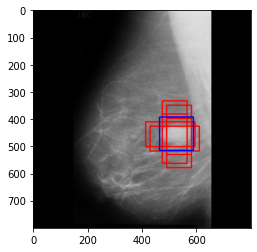

In [65]:
# visualizing foreground proposals
img_path = Path(train_re.iloc[75,1])
img_ = cv2.imread(str(img_path))

rois = train_re.iloc[75, -1]
bbox_list = train_re.iloc[75, 17]

for i in range(len(rois)): 
    # visualizing foreground proposals
    x_min = int(rois[i][0])
    y_min = int(rois[i][1])
    x_max = int(rois[i][2])
    y_max = int(rois[i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

# plot ground truth
cv2.rectangle(img_, (int(bbox_list[0]), int(bbox_list[1])), (int(bbox_list[2]), int(bbox_list[3])), color=(0, 0, 255), thickness=3)

plt.imshow(img_)
plt.show()

Let's evaluate the model by measuring how many images had at least 1 predicted box (ROI) with at least an IoU over 50%.

In [66]:
boxes_to_predict = len(train_re) # we know there's one box per image to predict

boxes_iou_50_predicted = []

idx = 0
for i in train_re['rois_pos']:
  if len(i) > 0:
    boxes_iou_50_predicted.append(idx)
  else:
    pass
  
  idx +=1

n_boxes_iou_50_predicted = len(boxes_iou_50_predicted)

metric = n_boxes_iou_50_predicted/boxes_to_predict

print('Percentage of correctly predicted boxes with an Intersection over Union score over 0.5 is', f'{metric:.2%}')
      

Percentage of correctly predicted boxes with an Intersection over Union score over 0.5 is 38.76%
